API dataset columns: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Location', 'Source']
Historical dataset columns: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Location', 'Source']
Common columns available: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Location', 'Source']

Date column types before conversion:
df_api Date type: datetime64[ns]
df_hist Date type: datetime64[ns]
Failed date conversions in df_api: 0
Failed date conversions in df_hist: 0
df_api Date type after conversion: datetime64[ns]
df_hist Date type after conversion: datetime64[ns]

Unified dataset shape: (37405, 7)
Data sources distribution:
Source
Historical    36913
API             492
Name: count, dtype: int64

First few rows:
                     Date  Latitude  Longitude   Depth  Magnitude  \
0 2023-02-17 09:37:34.868   -6.5986   132.0763  38.615        6.1   
1 2023-02-16 05:37:05.138  -15.0912   167.0294  36.029        5.6   
2 2023-02-15 18:10:10.060   12.3238   123.8662  20.

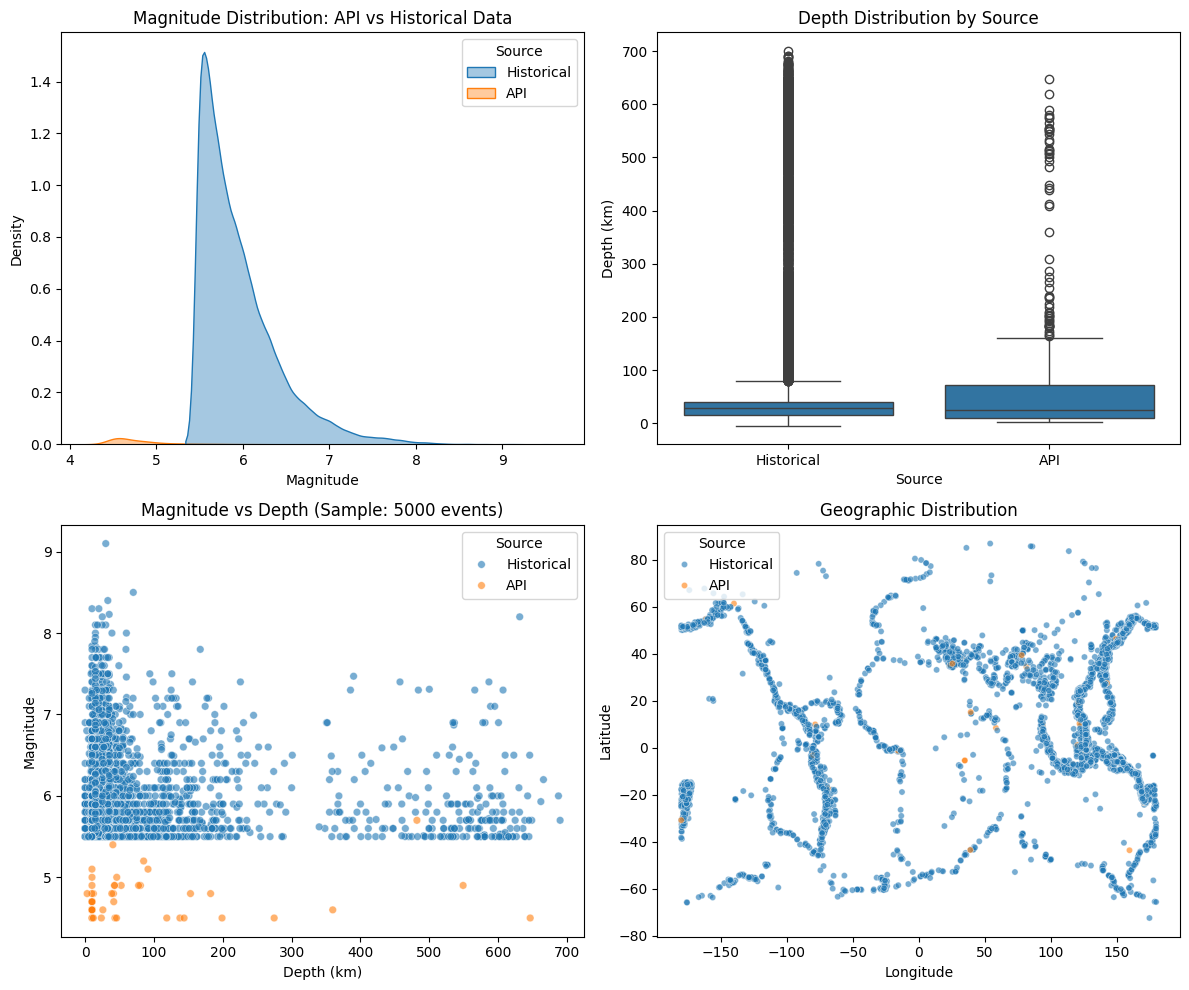

Date column type before Year extraction: datetime64[ns]


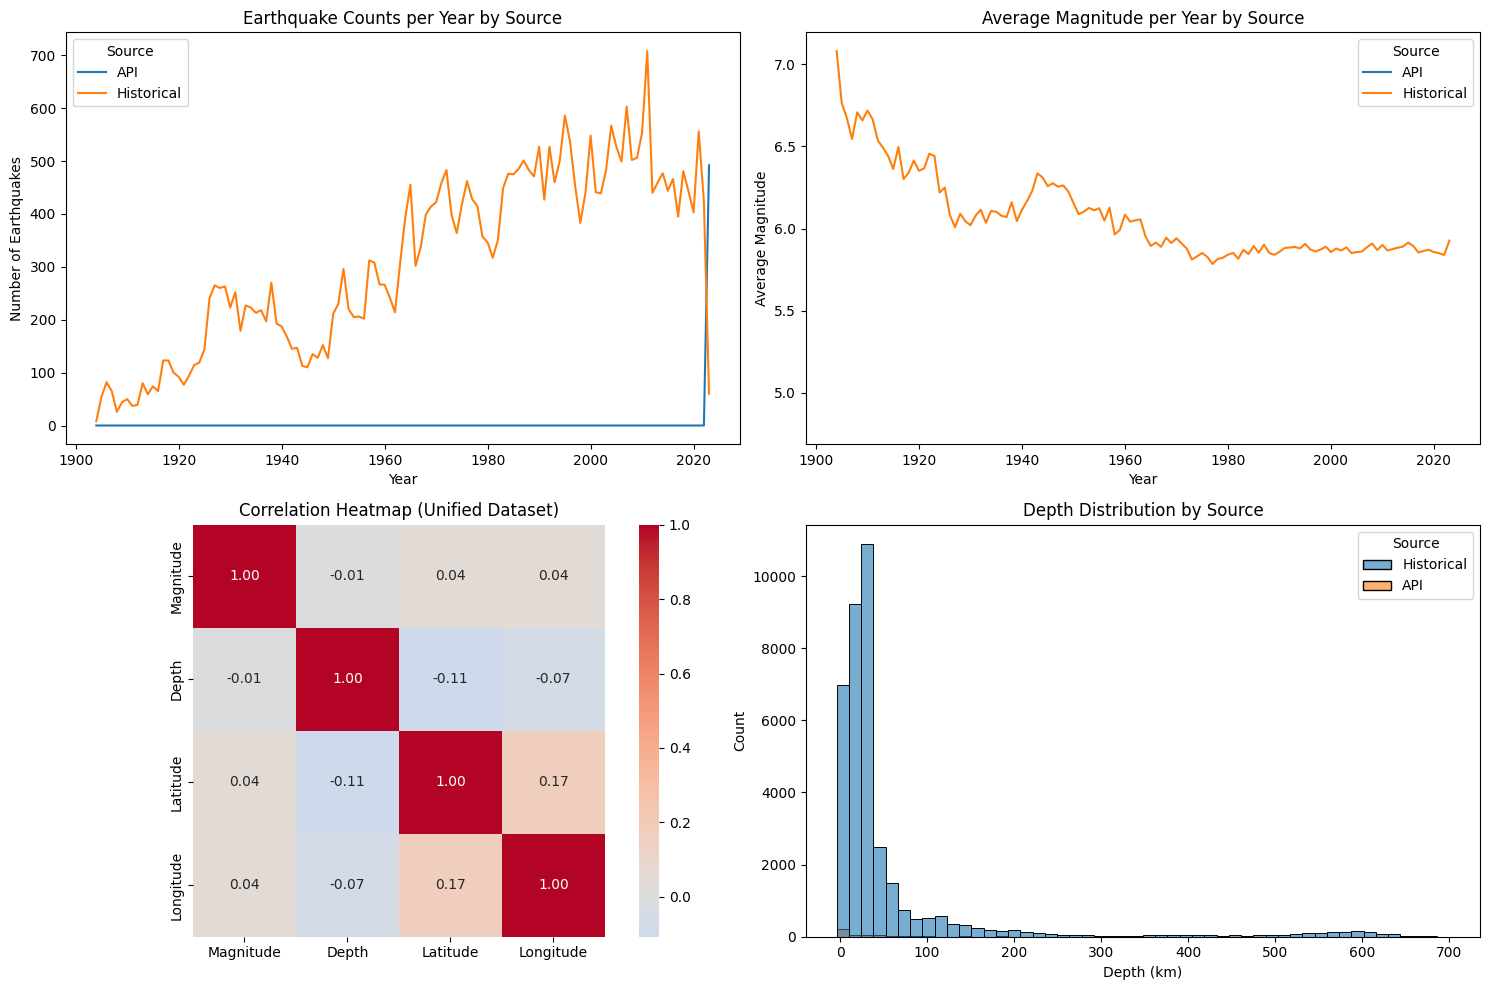

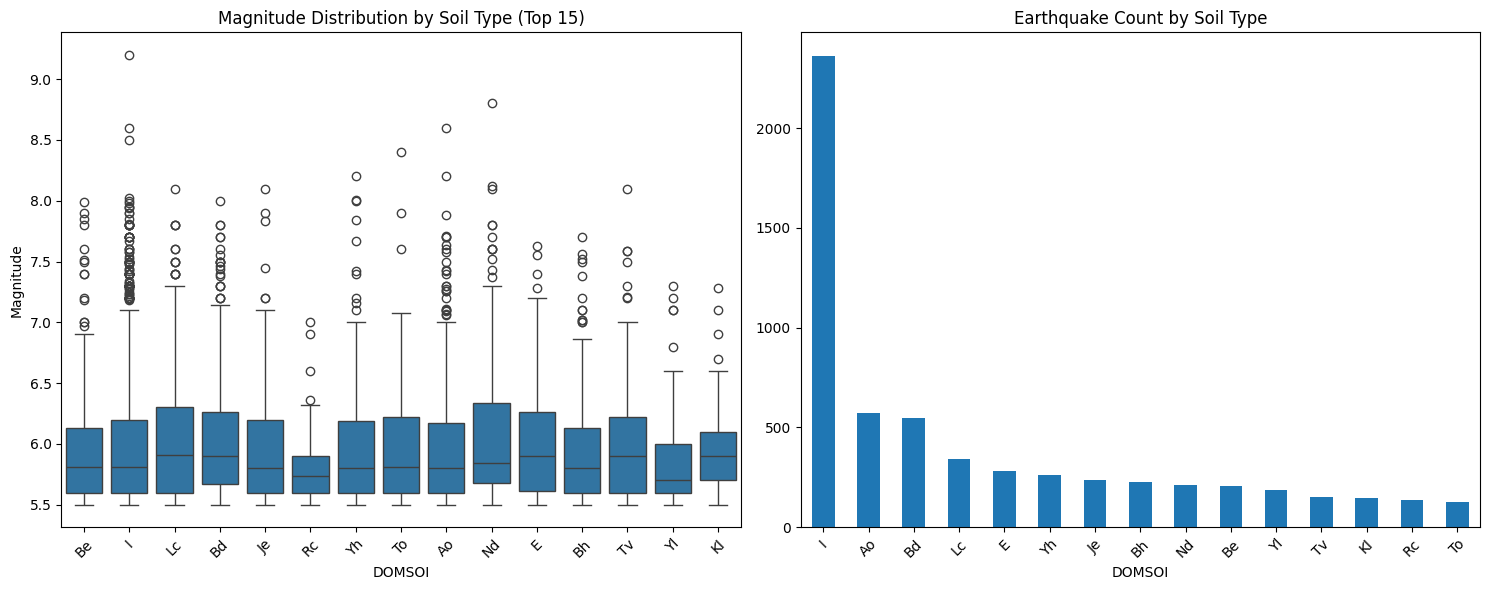


=== SOIL TYPE ANALYSIS ===
       Magnitude                  Depth         
           count   mean    std     mean      std
DOMSOI                                          
Af            96  5.989  0.461   31.644   65.190
Ag             3  6.260  0.560   21.667   11.547
Ah           111  6.050  0.508   34.258   26.189
Ao           572  5.971  0.500   44.783   57.205
Ap            32  6.322  0.605  406.278  264.426
Bc            69  5.976  0.470   34.178   25.301
Bd           547  6.035  0.495   43.543   49.010
Be           205  5.972  0.519   33.914   50.390
Bf            30  5.908  0.417   47.782   33.491
Bg            48  6.032  0.518   43.678   40.545


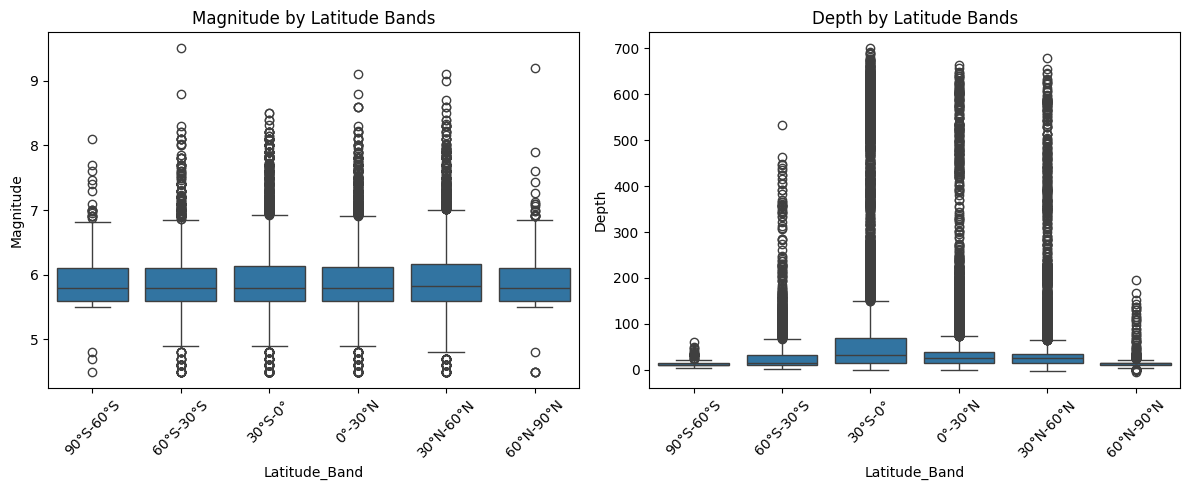


=== UNIFIED DATASET SUMMARY ===
Total earthquakes: 37,405
Time range: 1904-04-04 10:02:34.560000 to 2023-08-31 21:43:25.888000
Geographic range: Lat(-77.1 to 87.2)
                 Lon(-180.0 to 180.0)
Magnitude range: 4.5 to 9.5
Depth range: -4.0 to 700.0 km

=== DATA QUALITY CHECK ===
Missing values per column:
Date                 0
Latitude             0
Longitude            0
Depth                0
Magnitude            0
Location             0
Source               0
merge_id             0
DOMSOI           28847
Year                 0
Latitude_Band        0
dtype: int64

Soil data coverage: 22.9%

Unified dataset saved to: unified_earthquake_data.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1. Align API + Historical datasets ---
print("API dataset columns:", df_api.columns.tolist())
print("Historical dataset columns:", df_hist.columns.tolist())

# Fix the column naming issue
df_api = df_api.rename(columns={
    "time": "Date",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "depth": "Depth",
    "magnitude": "Magnitude",
    "place": "Location"
})

# Add source identifiers
df_api["Source"] = "API"
df_hist["Source"] = "Historical"

# Handle missing 'Location' column if it doesn't exist in df_api
if 'Location' not in df_api.columns:
    df_api['Location'] = "Unknown"

# Keep consistent columns (ensure they exist in both datasets)
available_common_cols = []
for col in ["Date", "Latitude", "Longitude", "Depth", "Magnitude", "Location", "Source"]:
    if col in df_api.columns and col in df_hist.columns:
        available_common_cols.append(col)

print("Common columns available:", available_common_cols)

df_api = df_api[available_common_cols]
df_hist = df_hist[available_common_cols]

# --- Step 2. Fix timezone compatibility issue ---
print("\nDate column types before conversion:")
print(f"df_api Date type: {df_api['Date'].dtype}")
print(f"df_hist Date type: {df_hist['Date'].dtype}")

# Convert both to timezone-naive datetime to avoid conflicts
df_api['Date'] = pd.to_datetime(df_api['Date'], errors='coerce')
df_hist['Date'] = pd.to_datetime(df_hist['Date'], errors='coerce')

# If historical data has timezone info, remove it
if df_hist['Date'].dtype == 'datetime64[ns, UTC]':
    df_hist['Date'] = df_hist['Date'].dt.tz_localize(None)

# Check for any failed conversions
print(f"Failed date conversions in df_api: {df_api['Date'].isna().sum()}")
print(f"Failed date conversions in df_hist: {df_hist['Date'].isna().sum()}")

# Remove rows with invalid dates
df_api = df_api.dropna(subset=['Date'])
df_hist = df_hist.dropna(subset=['Date'])

print(f"df_api Date type after conversion: {df_api['Date'].dtype}")
print(f"df_hist Date type after conversion: {df_hist['Date'].dtype}")

# --- Step 3. Merge both datasets ---
df_all = pd.concat([df_hist, df_api], ignore_index=True)

print("\nUnified dataset shape:", df_all.shape)
print("Data sources distribution:")
print(df_all['Source'].value_counts())
print("\nFirst few rows:")
print(df_all.head())
print(f"Unified Date type: {df_all['Date'].dtype}")

# --- Step 4. Attach Soil/Geological Data ---
# Create a unique identifier for merging
df_all['merge_id'] = df_all['Latitude'].round(3).astype(str) + '_' + df_all['Longitude'].round(3).astype(str)

# Prepare soil data with same identifier
if 'eq_with_soil' in globals():
    eq_with_soil['merge_id'] = eq_with_soil['Latitude'].round(3).astype(str) + '_' + eq_with_soil['Longitude'].round(3).astype(str)

    # Merge soil data
    df_all_geo = pd.merge(
        df_all,
        eq_with_soil[['merge_id', 'DOMSOI']].drop_duplicates(),
        on='merge_id',
        how='left'
    )
else:
    print("Soil data not available, proceeding without it")
    df_all_geo = df_all.copy()
    df_all_geo['DOMSOI'] = np.nan

print("\nUnified dataset with soil shape:", df_all_geo.shape)
print("Soil data coverage:", df_all_geo['DOMSOI'].notna().sum(), "out of", len(df_all_geo))
print("\nSample of unified dataset:")
print(df_all_geo.sample(5))

# --- Step 5. Comprehensive Exploratory Data Analysis Across Sources ---

# 1. Basic statistics by source
print("\n=== BASIC STATISTICS BY SOURCE ===")
print(df_all_geo.groupby('Source').agg({
    'Magnitude': ['count', 'mean', 'std', 'min', 'max'],
    'Depth': ['mean', 'std', 'min', 'max'],
    'Latitude': ['mean', 'std'],
    'Longitude': ['mean', 'std']
}).round(3))

# 2. Distribution plots
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.kdeplot(data=df_all_geo, x="Magnitude", hue="Source", fill=True, alpha=0.4)
plt.title("Magnitude Distribution: API vs Historical Data")
plt.xlabel("Magnitude")

plt.subplot(2, 2, 2)
sns.boxplot(data=df_all_geo, x="Source", y="Depth")
plt.title("Depth Distribution by Source")
plt.ylabel("Depth (km)")

plt.subplot(2, 2, 3)
sample_size = min(5000, len(df_all_geo))
sns.scatterplot(data=df_all_geo.sample(sample_size, random_state=42),
                x="Depth", y="Magnitude", hue="Source", alpha=0.6, s=30)
plt.title(f"Magnitude vs Depth (Sample: {sample_size} events)")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
sns.scatterplot(data=df_all_geo.sample(sample_size, random_state=42),
                x="Longitude", y="Latitude", hue="Source", alpha=0.6, s=20)
plt.title("Geographic Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()

# 6. Time-based analysis (now that dates are properly formatted)
# Double-check date type before extracting year
print(f"Date column type before Year extraction: {df_all_geo['Date'].dtype}")

# If still not datetime, force conversion
if not pd.api.types.is_datetime64_any_dtype(df_all_geo['Date']):
    df_all_geo['Date'] = pd.to_datetime(df_all_geo['Date'], errors='coerce')
    # Remove any rows with invalid dates
    df_all_geo = df_all_geo.dropna(subset=['Date'])

df_all_geo['Year'] = df_all_geo['Date'].dt.year

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
yearly_counts = df_all_geo.groupby(['Year', 'Source']).size().unstack(fill_value=0)
yearly_counts.plot(kind='line', ax=plt.gca())
plt.title("Earthquake Counts per Year by Source")
plt.xlabel("Year")
plt.ylabel("Number of Earthquakes")
plt.legend(title="Source")

plt.subplot(2, 2, 2)
yearly_magnitude = df_all_geo.groupby(['Year', 'Source'])['Magnitude'].mean().unstack()
yearly_magnitude.plot(kind='line', ax=plt.gca())
plt.title("Average Magnitude per Year by Source")
plt.xlabel("Year")
plt.ylabel("Average Magnitude")
plt.legend(title="Source")

plt.subplot(2, 2, 3)
correlation_data = df_all_geo[['Magnitude', 'Depth', 'Latitude', 'Longitude']].corr()
sns.heatmap(correlation_data, annot=True, cmap="coolwarm", center=0,
            square=True, fmt=".2f")
plt.title("Correlation Heatmap (Unified Dataset)")

plt.subplot(2, 2, 4)
sns.histplot(data=df_all_geo, x='Depth', hue='Source', bins=50, alpha=0.6)
plt.title("Depth Distribution by Source")
plt.xlabel("Depth (km)")

plt.tight_layout()
plt.show()

# 7. Soil type analysis (if available)
if df_all_geo['DOMSOI'].notna().sum() > 0:
    plt.figure(figsize=(15, 6))

    top_soils = df_all_geo['DOMSOI'].value_counts().head(15).index
    soil_data_subset = df_all_geo[df_all_geo['DOMSOI'].isin(top_soils)]

    plt.subplot(1, 2, 1)
    sns.boxplot(data=soil_data_subset, x="DOMSOI", y="Magnitude")
    plt.title("Magnitude Distribution by Soil Type (Top 15)")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    soil_counts = soil_data_subset['DOMSOI'].value_counts()
    soil_counts.plot(kind='bar')
    plt.title("Earthquake Count by Soil Type")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n=== SOIL TYPE ANALYSIS ===")
    soil_stats = df_all_geo.groupby('DOMSOI').agg({
        'Magnitude': ['count', 'mean', 'std'],
        'Depth': ['mean', 'std']
    }).round(3)
    print(soil_stats.head(10))

# 8. Advanced spatial analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_all_geo['Latitude_Band'] = pd.cut(df_all_geo['Latitude'],
                                    bins=np.arange(-90, 91, 30),
                                    labels=['90°S-60°S', '60°S-30°S', '30°S-0°',
                                           '0°-30°N', '30°N-60°N', '60°N-90°N'])
sns.boxplot(data=df_all_geo, x='Latitude_Band', y='Magnitude')
plt.title("Magnitude by Latitude Bands")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_all_geo, x='Latitude_Band', y='Depth')
plt.title("Depth by Latitude Bands")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 9. Summary statistics for the unified dataset
print("\n=== UNIFIED DATASET SUMMARY ===")
print(f"Total earthquakes: {len(df_all_geo):,}")
print(f"Time range: {df_all_geo['Date'].min()} to {df_all_geo['Date'].max()}")
print(f"Geographic range: Lat({df_all_geo['Latitude'].min():.1f} to {df_all_geo['Latitude'].max():.1f})")
print(f"                 Lon({df_all_geo['Longitude'].min():.1f} to {df_all_geo['Longitude'].max():.1f})")
print(f"Magnitude range: {df_all_geo['Magnitude'].min():.1f} to {df_all_geo['Magnitude'].max():.1f}")
print(f"Depth range: {df_all_geo['Depth'].min():.1f} to {df_all_geo['Depth'].max():.1f} km")

# 10. Data quality check
print("\n=== DATA QUALITY CHECK ===")
print("Missing values per column:")
print(df_all_geo.isnull().sum())
print(f"\nSoil data coverage: {df_all_geo['DOMSOI'].notna().mean():.1%}")

# Save the unified dataset for future use
df_all_geo.to_csv('/content/unified_earthquake_data.csv', index=False)
print("\nUnified dataset saved to: unified_earthquake_data.csv")

In [ ]:
# Load unified dataset
import pandas as pd

df = pd.read_csv("/content/unified_earthquake_data.csv")

print("Missing values per column before cleaning:")
print(df.isnull().sum())

# --- Strategy ---
# Numeric: fill with median
num_cols = ['Magnitude', 'Depth']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Categorical: fill with mode
cat_cols = ['Location', 'DOMSOI']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after imputation:")
print(df.isnull().sum())

# Save intermediate version
df.to_csv("/content/earthquake_cleaned_day1.csv", index=False)


Missing values per column before cleaning:
Date                 0
Latitude             0
Longitude            0
Depth                0
Magnitude            0
Location             0
Source               0
merge_id             0
DOMSOI           28847
Year                 0
Latitude_Band        0
dtype: int64

Missing values after imputation:
Date             0
Latitude         0
Longitude        0
Depth            0
Magnitude        0
Location         0
Source           0
merge_id         0
DOMSOI           0
Year             0
Latitude_Band    0
dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/earthquake_cleaned_day1.csv")

# Select numeric features
numeric_features = ['Magnitude', 'Depth']

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

print(df_scaled[numeric_features].describe())

# Save scaled dataset
df_scaled.to_csv("/content/earthquake_scaled_day2.csv", index=False)


          Magnitude         Depth
count  3.740500e+04  3.740500e+04
mean   1.057693e-15  4.862958e-17
std    1.000013e+00  1.000013e+00
min   -3.035563e+00 -5.725798e-01
25%   -7.058295e-01 -3.993082e-01
50%   -2.822417e-01 -2.752822e-01
75%    4.166783e-01 -1.567280e-01
max    7.554134e+00  5.847588e+00


In [ ]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/content/earthquake_scaled_day2.csv")

# Encode Soil Type (DOMSOI)
if 'DOMSOI' in df.columns:
    encoder = LabelEncoder()
    df['SoilType_Encoded'] = encoder.fit_transform(df['DOMSOI'])
else:
    df['SoilType_Encoded'] = -1  # fallback if missing

# Encode Location (optional, may be too high-cardinality)
df['Location_Encoded'] = LabelEncoder().fit_transform(df['Location'])

print(df[['DOMSOI', 'SoilType_Encoded']].head())

# Save encoded dataset
df.to_csv("/content/earthquake_encoded_day3.csv", index=False)


  DOMSOI  SoilType_Encoded
0      I                38
1     Bf                 8
2      I                38
3      I                38
4     Be                 7


In [ ]:
import numpy as np
from sklearn.cluster import KMeans

df = pd.read_csv("/content/earthquake_encoded_day3.csv")

# 1. Magnitude Category
df['Magnitude_Class'] = pd.cut(
    df['Magnitude'],
    bins=[0, 4, 6, 7, 10],
    labels=['Low', 'Moderate', 'Strong', 'Major']
)

# 2. Depth Category
df['Depth_Class'] = pd.cut(
    df['Depth'],
    bins=[-1, 70, 300, 700],
    labels=['Shallow', 'Intermediate', 'Deep']
)

# 3. Risk Score (simple weighted sum)
df['Risk_Score'] = (
    (df['Magnitude'] * 0.7) +
    (np.log1p(df['Depth']) * 0.3)
)

# 4. Spatial Clusters
coords = df[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['Region_Cluster'] = kmeans.fit_predict(coords)

print(df[['Magnitude', 'Depth', 'Risk_Score', 'Region_Cluster']].head())

# Save engineered dataset
df.to_csv("/content/earthquake_features_day4.csv", index=False)


   Magnitude     Depth  Risk_Score  Region_Cluster
0   0.353140 -0.183950    0.186214               3
1  -0.705830 -0.207533   -0.563862               3
2   0.353140 -0.352908    0.116618               3
3  -0.494036  0.141664   -0.306079               3
4  -0.705830 -0.444906   -0.670666               2


In [ ]:
# Load latest version
df_final = pd.read_csv("/content/earthquake_features_day4.csv")

print("Final dataset shape:", df_final.shape)
print("Final columns:", df_final.columns.tolist())

# Save final dataset for modeling
df_final.to_csv("/content/earthquake_preprocessed_week2.csv", index=False)


Final dataset shape: (37405, 17)
Final columns: ['Date', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Location', 'Source', 'merge_id', 'DOMSOI', 'Year', 'Latitude_Band', 'SoilType_Encoded', 'Location_Encoded', 'Magnitude_Class', 'Depth_Class', 'Risk_Score', 'Region_Cluster']


In [ ]:
import pandas as pd

df = pd.read_csv("/content/earthquake_preprocessed_week2.csv")

# Example: Add target labels (Magnitude_Class from Week 2)
print("Sample Magnitude Classes:")
print(df[['Magnitude', 'Magnitude_Class']].head())

# Regression target = Magnitude (numeric)
# Classification target = Magnitude_Class (categorical)


Sample Magnitude Classes:
   Magnitude Magnitude_Class
0   0.353140             Low
1  -0.705830             NaN
2   0.353140             Low
3  -0.494036             NaN
4  -0.705830             NaN
